In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.10/08


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Cuts declaration

In [5]:
analysis_cuts = [
 'mass_mumu < 3.174',
 'mass_mumu > 3.013',
 'mass_piK > 0.82',
 'mass_piK < 0.96',
 'mum_pt > 3.5',
 'mup_pt > 3.5',
 'Jpsi_pt > 7',
 'pval_mumu > 0.1',
 'mum_eta > -2.2',
 'mup_eta > -2.2',
 'mum_eta < 2.2',
 'mup_eta < 2.2',
 'cosT_Jpsi_PV > 0.95',
 'mum_dxy < 3',
 'mup_dxy < 3',
 'pval_piK > 0.1',
 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)',
 'mass_KK > 1.035',
 'K_sigdxy_PV > 2',
 'pi_sigdxy_PV > 2',
 'sigdxy_vtxKst_PV > 5',
 'K_pt > 0.8',
 'pval_mumupiK > 0.1',
 'pi_pt > 0.8',
 'mass_mumupiK > 5.02',
 'mass_mumupiK < 5.55'
]
analysis_cuts_str = ' && '.join(analysis_cuts)

# Load data

In [6]:
dataDir = '../data/cmsRD'
datasets_loc = []
datasets_loc += glob(dataDir + '/ParkingBPH*/*2018A*B2JpsiKst_191019*')
# datasets_loc += glob(dataDir + '/ParkingBPH1/*2018D-*B2JpsiKst_191017*')

for d in datasets_loc: print d

../data/cmsRD/ParkingBPH1/Run2018A-05May2019-v1_RDntuplizer_B2JpsiKst_191019_CAND.root
../data/cmsRD/ParkingBPH2/Run2018A-05May2019-v1_RDntuplizer_B2JpsiKst_191019_CAND.root
../data/cmsRD/ParkingBPH3/Run2018A-05May2019-v1_RDntuplizer_B2JpsiKst_191019_CAND.root
../data/cmsRD/ParkingBPH4/Run2018A-05May2019-v1_RDntuplizer_B2JpsiKst_191019_CAND.root
../data/cmsRD/ParkingBPH5/Run2018A-05May2019-v1_RDntuplizer_B2JpsiKst_191019_CAND.root
../data/cmsRD/ParkingBPH6/Run2018A-05May2019-v1_RDntuplizer_B2JpsiKst_191019_CAND.root


In [7]:
lumi_tot, lumi_dic = getLumiReport(datasets_loc)
CMS_lumi.integrated_lumi = lumi_tot

Lumi tot: 4.6 fb^-1
Lumi analyzed: 11.3%


In [8]:
treeRD = rt.TChain('outA/Tevts')
for floc in datasets_loc:
   treeRD.Add(floc)
print 'N evts: {:.0f}'.format(treeRD.GetEntries(analysis_cuts_str))

N evts: 17430


# Load MC

In [9]:
mcDir = '../data/cmsMC_private'

In [10]:
mcsets_loc = glob(mcDir + '/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV/jobs_B2JpsiKst/out_CAND*.root')
treeMC_hard = rt.TChain('outA/Tevts')
for floc in mcsets_loc:
    treeMC_hard.Add(floc)
print 'N files: {:.0f}'.format(len(mcsets_loc))
print 'N evts: {:.0f}'.format(treeMC_hard.GetEntries(analysis_cuts_str))

N files: 45
N evts: 53590


In [11]:
mcsets_loc = glob(mcDir + '/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_SVV/jobs_B2JpsiKst/out_CAND*.root')
treeMC_soft = rt.TChain('outA/Tevts')
for floc in mcsets_loc:
    treeMC_soft.Add(floc)
print 'N files: {:.0f}'.format(len(mcsets_loc))
print 'N evts: {:.0f}'.format(treeMC_soft.GetEntries(analysis_cuts_str))

N files: 9
N evts: 12044


# Analyze data

### Fit the whole dataset

In [ ]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[30, 5.02, 5.55]
               )
treeRD.Project('h', 'mass_mumupiK', analysis_cuts_str)
h.Sumw2()

In [ ]:
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', h.binning[1], h.binning[2], 'GeV')

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.02, 0.00005, 0.1, 'GeV') 
# pdf_sig = rt.RooGaussian('gaus','sig pdf', mass, mean, sigma)

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# alpha = rt.RooRealVar('alpha', '#alpha', 2, -5, 5, 'GeV')
# nCB = rt.RooRealVar('nCB', 'n_{CB}', 2, -10, 10, 'GeV')
# pdf_sig = rt.RooCBShape('gaus','sig pdf', mass, mean, sigma, alpha, nCB)

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
# pAsym.setConstant(rt.kTRUE)
rho1 = rt.RooRealVar('rho1', '#rho_{1}', 0, -10, 0)
# rho1.setConstant(rt.kTRUE)
rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)

N_tot = h.Integral(1, h.binning[0])
nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [ ]:
lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)

# a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
# a1 = rt.RooRealVar('a1', 'a1', 0.1, -10, 1000)
# a2 = rt.RooRealVar('a2', 'a2', 0.1, -100, 1000)
# pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(a1, a2), 1)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 100*N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

In [ ]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.binning[0]-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())

In [ ]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()), rf.MarkerStyle(15))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(2))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

pTxt = rt.TPaveText(5.05, 0.2*h.GetMaximum(), 5.2, h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))
pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()

### Create a skimmed tree

In [ ]:
output = []
N_accepted_cand = []

import operator
ops = {'>': operator.gt, '<': operator.lt, }

pb = ProgressBar(maxEntry=treeRD.GetEntries())
for i_ev, ev in enumerate(treeRD):
    pb.show(i_ev)
    N_acc = 0
    for j in range(ev.pval_mumupiK.size()):
        accept = abs(ev.mass_piK[j] - 0.892) < abs(ev.mass_piK_CPconj[j] - 0.892)
        for c_str in analysis_cuts:
            if c_str == 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)': continue
            if not accept:
                break
            aux = c_str.split(' ')
            if len(aux) != 3:
                raise
            x = getattr(ev, aux[0])[j]
            accept = ops[aux[1]](x, float(aux[2]))
        if accept:
            N_acc += 1
            output.append((ev.mass_mumupiK[j], 
                           ev.B_mumupiK_pt[j], 
                           ev.B_mumupiK_eta[j],
                           ev.Jpsi_pt[j],
                           ev.mum_pt[j],
                           ev.mum_eta[j],
                           ev.mum_isTrg[j],
                           ev.mup_eta[j],
                           ev.mup_pt[j],
                           ev.mup_isTrg[j],
                           ev.Kst_pt[j],
                           ev.Kst_eta[j],
                           ev.K_pt[j],
                           ev.K_eta[j],
                           ev.pi_pt[j],
                           ev.pi_eta[j],
                          ))
    if N_acc > 0:
        N_accepted_cand.append(N_acc)

print len(output)
dic = {i:N_accepted_cand.count(i) for i in range(1, np.max(N_accepted_cand)+1)}
print dic

import root_numpy as rtnp
leafs_names = ['mass_mumupiK', 'B_pt', 'B_eta', 'Jpsi_pt', 'mum_pt', 'mum_eta', 'mum_isTrg', 'mup_eta', 'mup_pt', 'mup_isTrg', 'Kst_pt', 'Kst_eta', 'K_pt', 'K_eta', 'pi_pt', 'pi_eta']

dtypes = []
for n in leafs_names:
    dtypes.append((n, np.float32))

# dtypes = [('mass_mumupiK', np.float32), ('B_pt', np.float32), ('B_eta', np.float32)]
a = np.array(output, dtype=dtypes)
skimmed_tree = rtnp.array2tree(a)
rtnp.array2root(a, '../data/cmsRD/skimmed/B2JpsiKst.root', treename='Tevts', mode='RECREATE')

In [ ]:
skimmed_file = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst.root', 'READ')
skimmed_tree = skimmed_file.Get('Tevts')
skimmed_tree.Print()

### Make sDataset

In [ ]:
v_B_pt = rt.RooRealVar('B_pt', 'p_{T}^{(B)}', 0, 500, 'GeV')
v_B_eta = rt.RooRealVar('B_eta', '#eta^{(B)}', -3, 3, 'GeV')

rt.RooAbsData.setDefaultStorageType(rt.RooAbsData.Tree)
ds = rt.RooDataSet('ds', 'ds', skimmed_tree, rt.RooArgSet(mass, v_B_eta, v_B_pt))#, v_B_eta))

In [ ]:
sData = rt.RooStats.SPlot('sData', 'sData', ds, pdf_tot, rt.RooArgList(nsig, nbkg))
sData.GetYieldFromSWeight('nsig_sw')

In [ ]:
f_sw = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst_sW.root', 'RECREATE')
treeRD_skimmed = ds.tree()
treeRD_skimmed.Write()
f_sw.Close()

In [12]:
f_sw = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst_sW.root', 'READ')
treeRD_skimmed = f_sw.Get('merged')
treeRD_skimmed.Print()

******************************************************************************
*Tree    :merged    : merged                                                 *
*Entries :    17471 : Total =         1024730 bytes  File  Size =     764113 *
*        :          : Tree compression factor =   1.00                       *
******************************************************************************
*Br    0 :mass_mumupiK : mass_mumupiK/D                                      *
*Entries :    17471 : Total  Size=     146736 bytes  All baskets in memory   *
*Baskets :       34 : Basket Size=       4096 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :B_eta     : B_eta/D                                                *
*Entries :    17471 : Total  Size=     146218 bytes  All baskets in memory   *
*Baskets :       34 : Basket Size=       4096 bytes  Compression=   1.00     *
*...................................................

# Analyze MC

In [ ]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=[30, 5.15, 5.4]
               )
treeMC.Project('h', 'mass_mumupiK', analysis_cuts_str)
h.Sumw2()

In [ ]:
N_tot = h.Integral(1, h.binning[0])
print N_tot
print h.Integral()

In [ ]:
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', h.binning[1], h.binning[2], 'GeV')

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.02, 0.00005, 0.1, 'GeV') 
# pdf_sig = rt.RooGaussian('gaus','sig pdf', mass, mean, sigma)

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# alpha = rt.RooRealVar('alpha', '#alpha', 2, -5, 5, 'GeV')
# nCB = rt.RooRealVar('nCB', 'n_{CB}', 2, -10, 10, 'GeV')
# pdf_sig = rt.RooCBShape('gaus','sig pdf', mass, mean, sigma, alpha, nCB)

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
rho1 = rt.RooRealVar('rho1', '#rho_{1}', 0, -10, 0)
rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)


nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [ ]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = pdf_sig_ext
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.binning[0]-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

In [ ]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(2))

pTxt = rt.TPaveText(h.GetBinCenter(1), 0.2*h.GetMaximum(), h.GetBinCenter(int(0.35*h.GetNbinsX())), h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

CMS_lumi.extraText = '     Simulation Preliminary'
CMS_lumi.integrated_lumi = ''
c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()

# Compare

### Closure variables

In [ ]:
b=[4, -0.5, 3.5]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='',
                axis_title=['J/#psi muons matched with trigger obj', '1/#sigma d#sigma/dN'],
                binning=b
               )
skimmed_tree.Project('hRD', 'mum_isTrg + mup_isTrg')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

colors = {'hard':rt.kRed, 'soft':rt.kBlue}
for k in ['hard', 'soft']:
    h = create_TH1D(np.zeros(0), name='hMC_'+k, 
                    title='',
                    binning=hRD.binning)
    globals()['treeMC_'+k].Project('hMC_'+k, 'mum_isTrg + mup_isTrg', analysis_cuts_str)
    h.Sumw2()
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[k])
    globals()['hMC_'+k] = h
    
leg = rt.TLegend(0.7, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data', 'lep')
leg.AddEntry(hMC_hard, 'Pythia Hard b#bar{b}', 'le')
leg.AddEntry(hMC_soft, 'Pythia Soft QCD', 'le')

CMS_lumi.extraText = '     Preliminary'
CMS_lumi.integrated_lumi = lumi_tot
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC_hard, hMC_soft], 'same')
c.SetLogy()
leg.Draw()

In [ ]:
b=[30, 0, 50]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='data',
                axis_title=['Leading muon p_{T} [GeV]', '1/#sigma d#sigma/dN'],
                binning=b,
                opt='overflow'
               )
skimmed_tree.Project('hRD', 'max(mum_pt, mup_pt)', 'mass_mumupiK > 5.18 && mass_mumupiK < 5.4')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

colors = {'hard':rt.kRed, 'soft':rt.kBlue}
for k in ['hard', 'soft']:
    h = create_TH1D(np.zeros(0), name='hMC_'+k, 
                    title='',
                    opt='overflow',
                    binning=hRD.binning)
    globals()['treeMC_'+k].Project('hMC_'+k, 'max(mum_pt, mup_pt)', analysis_cuts_str)
    h.Sumw2()
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[k])
    globals()['hMC_'+k] = h
hMC_hard.SetTitle('Pythia Hard b#bar{b}')
hMC_soft.SetTitle('Pythia Soft QCD')

CMS_lumi.extraText = '      Preliminary'
c = make_ratio_plot([hRD, hMC_hard, hMC_soft], ratio_bounds=[0.2, 15], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

In [ ]:
add_cut = ' && !(mum_pt>mup_pt?mum_isTrg:mup_isTrg)'
b=[30, 0, 50]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='data',
                axis_title=['Leading muon p_{T} [GeV]', '1/#sigma d#sigma/dN'],
                binning=b,
                opt='overflow'
               )
skimmed_tree.Project('hRD', 'max(mum_pt, mup_pt)', 'mass_mumupiK > 5.18 && mass_mumupiK < 5.4 ' + add_cut)
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

colors = {'hard':rt.kRed, 'soft':rt.kBlue}
for k in ['hard', 'soft']:
    h = create_TH1D(np.zeros(0), name='hMC_'+k, 
                    title='',
                    opt='overflow',
                    binning=hRD.binning)
    globals()['treeMC_'+k].Project('hMC_'+k, 'max(mum_pt, mup_pt)', analysis_cuts_str + add_cut)
    h.Sumw2()
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[k])
    globals()['hMC_'+k] = h
hMC_hard.SetTitle('Pythia Hard b#bar{b}')
hMC_soft.SetTitle('Pythia Soft QCD')

CMS_lumi.extraText = '      Preliminary'
c = make_ratio_plot([hRD, hMC_hard, hMC_soft], ratio_bounds=[0.2, 15], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

In [ ]:
b=[30, 0, 50, 30, 0, 2.5]
hRD = create_TH2D(np.zeros((0, 2)), name='hRD',
                title='data',
                axis_title=['Leading muon p_{T} [GeV]', 'Leading muon |#eta|', '1/#sigma d#sigma/dN'],
                binning=b
               )
skimmed_tree.Project('hRD', 'abs(mum_pt>mup_pt?mum_eta:mup_eta) : max(mum_pt, mup_pt)','mass_mumupiK > 5.18 && mass_mumupiK < 5.4')
c = rt.TCanvas('c', 'c', 800,600)
hRD.Draw('colz')
c.Draw()

In [ ]:
b=[30, 0, 50, 30, 0, 2.5]
hRD = create_TH2D(np.zeros((0, 2)), name='hRD',
                title='data',
                axis_title=['Leading muon p_{T} [GeV]', 'Leading muon |#eta|', '1/#sigma d#sigma/dN'],
                binning=b
               )
treeMC_hard.Project('hRD', 'abs(mum_pt>mup_pt?mum_eta:mup_eta) : max(mum_pt, mup_pt)','mass_mumupiK > 5.18 && mass_mumupiK < 5.4')
c = rt.TCanvas('c', 'c', 800,600)
hRD.Draw('colz')
c.Draw()

In [ ]:
b=[30, 0, 50]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='data',
                axis_title=['Sub-leading muon p_{T} [GeV]', '1/#sigma d#sigma/dN'],
                binning=b,
                opt='overflow'
               )
skimmed_tree.Project('hRD', 'min(mum_pt, mup_pt)', 'mass_mumupiK > 5.18 && mass_mumupiK < 5.4')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

colors = {'hard':rt.kRed, 'soft':rt.kBlue}
for k in ['hard', 'soft']:
    h = create_TH1D(np.zeros(0), name='hMC_'+k, 
                    title='',
                    opt='overflow',
                    binning=hRD.binning)
    globals()['treeMC_'+k].Project('hMC_'+k, 'min(mum_pt, mup_pt)', analysis_cuts_str)
    h.Sumw2()
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[k])
    globals()['hMC_'+k] = h
hMC_hard.SetTitle('Pythia Hard b#bar{b}')
hMC_soft.SetTitle('Pythia Soft QCD')

CMS_lumi.extraText = '      Preliminary'
c = make_ratio_plot([hRD, hMC_hard, hMC_soft], ratio_bounds=[0.2, 15], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

In [ ]:
b=[30, 0, 50]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='data',
                axis_title=['J/#psi p_{T} [GeV]', '1/#sigma d#sigma/dN'],
                binning=b,
                opt='overflow'
               )
skimmed_tree.Project('hRD', 'Jpsi_pt', 'mass_mumupiK > 5.18 && mass_mumupiK < 5.4')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

colors = {'hard':rt.kRed, 'soft':rt.kBlue}
for k in ['hard', 'soft']:
    h = create_TH1D(np.zeros(0), name='hMC_'+k, 
                    title='',
                    opt='overflow',
                    binning=hRD.binning)
    globals()['treeMC_'+k].Project('hMC_'+k, 'Jpsi_pt', analysis_cuts_str)
    h.Sumw2()
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[k])
    globals()['hMC_'+k] = h
hMC_hard.SetTitle('Pythia Hard b#bar{b}')
hMC_soft.SetTitle('Pythia Soft QCD')

CMS_lumi.extraText = '      Preliminary'
c = make_ratio_plot([hRD, hMC_hard, hMC_soft], ratio_bounds=[0.2, 15], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

In [ ]:
b=[30, 0, 50]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='data',
                axis_title=['K* p_{T} [GeV]', '1/#sigma d#sigma/dN'],
                binning=b,
                opt='overflow'
               )
skimmed_tree.Project('hRD', 'Kst_pt', 'mass_mumupiK > 5.18 && mass_mumupiK < 5.4')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

colors = {'hard':rt.kRed, 'soft':rt.kBlue}
for k in ['hard', 'soft']:
    h = create_TH1D(np.zeros(0), name='hMC_'+k, 
                    title='',
                    opt='overflow',
                    binning=hRD.binning)
    globals()['treeMC_'+k].Project('hMC_'+k, 'Kst_pt', analysis_cuts_str)
    h.Sumw2()
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[k])
    globals()['hMC_'+k] = h
hMC_hard.SetTitle('Pythia Hard b#bar{b}')
hMC_soft.SetTitle('Pythia Soft QCD')

CMS_lumi.extraText = '      Preliminary'
c = make_ratio_plot([hRD, hMC_hard, hMC_soft], ratio_bounds=[0.2, 15], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

In [ ]:
b=[30, 5.15, 5.4]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', '1/#sigma d#sigma/dm / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                binning=b
               )
treeRD_skimmed.Project('hRD', 'mass_mumupiK', 'L_nsig')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

colors = {'hard':rt.kRed, 'soft':rt.kBlue}
for k in ['hard', 'soft']:
    h = create_TH1D(np.zeros(0), name='hMC_'+k, 
                    title='',
                    binning=hRD.binning)
    globals()['treeMC_'+k].Project('hMC_'+k, 'mass_mumupiK', analysis_cuts_str)
    h.Sumw2()
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[k])
    globals()['hMC_'+k] = h
    
leg = rt.TLegend(0.7, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMC_hard, 'Pythia Hard b#bar{b}', 'le')
leg.AddEntry(hMC_soft, 'Pythia Soft QCD', 'le')

CMS_lumi.extraText = '     Preliminary'
CMS_lumi.integrated_lumi = lumi_tot
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC_hard, hMC_soft], 'same')
leg.Draw()

### The true B spectrum

<ROOT.TLegendEntry object ("TLegendEntry") at 0x7fa0b00dc170>

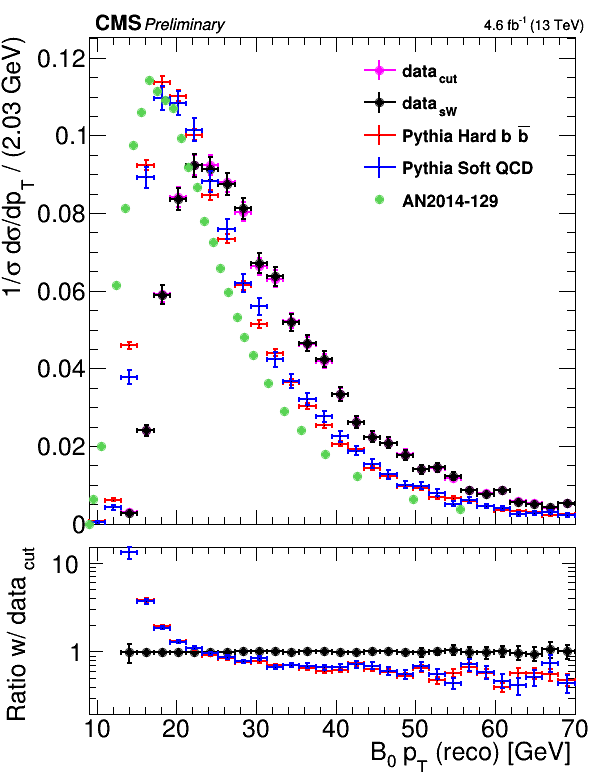

In [13]:
b = [30, 9, 70.]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='data_{sW}',
                axis_title=['B_{0} p_{T} (reco) [GeV]', 
                            '1/#sigma d#sigma/dp_{T} / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                binning=b,
                opt='overflow+underflow'
               )
treeRD_skimmed.Project('hRD', 'B_pt', 'nsig_sw')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

hRD_nosW = create_TH1D(np.zeros(0), name='hRD_nosW',
                title='data_{cut}', 
                axis_title=['B_{0} p_{T} (reco) [GeV]', 
                            '1/#sigma d#sigma/dp_{T} / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                binning=b,
                opt='overflow+underflow'
               )
treeRD_skimmed.Project('hRD_nosW', 'B_pt', 'mass_mumupiK > 5.18 && mass_mumupiK < 5.4')
hRD_nosW.Sumw2()
hRD_nosW.Scale(1./hRD_nosW.Integral())
hRD_nosW.SetMarkerStyle(15)
hRD_nosW.SetLineColor(rt.kMagenta)
hRD_nosW.SetMarkerColor(rt.kMagenta)

colors = {'hard':rt.kRed, 'soft':rt.kBlue}
for k in ['hard', 'soft']:
    h = create_TH1D(np.zeros(0), name='hMC_'+k, binning=hRD.binning, opt='overflow+underflow')
    globals()['treeMC_'+k].Project('hMC_'+k, 'B_mumupiK_pt', analysis_cuts_str)
    h.Sumw2()
    h.Scale(1./h.Integral())
    h.SetLineColor(colors[k])
    globals()['hMC_'+k] = h
hMC_hard.SetTitle('Pythia Hard b#bar{b}')
hMC_soft.SetTitle('Pythia Soft QCD')

CMS_lumi.extraText = '      Preliminary'
c = make_ratio_plot([hRD_nosW, hRD, hMC_hard, hMC_soft], ratio_bounds=[0.2, 15], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

c.pad1.cd()
arr = np.loadtxt('../data/cmsRD/CMS-AN2014-129_B0_pT_datathief.txt', delimiter=',')
integral = np.trapz(arr[:,1], arr[:,0])
arr[:, 1] *= float((b[2]-b[1])/b[0])/integral

gr_AN14_129 = rt.TGraph(arr.shape[0])
for i, (x, y) in enumerate(zip(arr[:,0], arr[:,1])):
    gr_AN14_129.SetPoint(i, x, y)
gr_AN14_129.SetMarkerColor(8)
gr_AN14_129.SetMarkerStyle(20)
gr_AN14_129.Draw('P')
c.leg.AddEntry(gr_AN14_129, 'AN2014-129', 'p')

In [65]:
dic = {'pt':[], 'w':[], 'w_err':[], 'wUp':[], 'wDown':[]}

def f_arb(x, value_at_beg):
    center = 0.5*(hRD.binning[2] + hRD.binning[1])
    k = (value_at_beg-1)/(hRD.binning[1] -  center)
    return k*(x - center)+1

fout = open('../data/calibration/B02JPsiKst_pt.txt', 'w')
fout.write('#'+'\t'.join(['pt','w', 'w_err', 'wUp', 'wDown'])+'\n')
for ib in range(1, hRD.GetNbinsX()+1):
    n = max(0, hRD.GetBinContent(ib))
    d = hMC_hard.GetBinContent(ib)
    en = 0.
    ed = 0.
    if n > 0: en = hRD.GetBinError(ib)/n
    if d > 0: ed = hMC_hard.GetBinError(ib)/d
    r = n/d
    dic['w'].append(r)
    if en != 0 and ed != 0:
        dr = r*np.hypot(en, ed)
    elif en == 0:
        dr = 0.5
    dic['w_err'].append(dr)
    pt = hRD.GetBinCenter(ib)
    dic['pt'].append(pt)
    
    dic['wUp'].append(r * f_arb(pt, 0.))
    dic['wDown'].append(r * f_arb(pt, 2.))
    
    fout.write('\t'.join(map(lambda x: '{:.3f}'.format(x), [pt, r, dr, r * f_arb(pt, 0.), r * f_arb(pt, 2.)]))+'\n')
fout.close()

Text(0,0.5,u'MC weight')

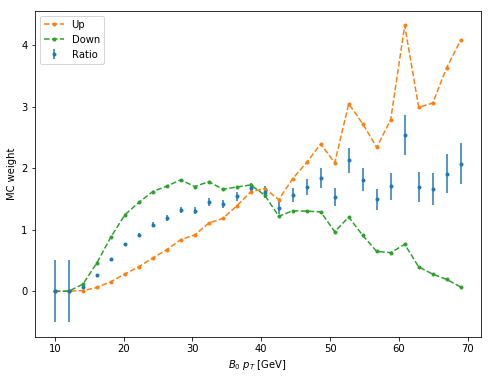

In [50]:
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.', label='Ratio')
plt.plot(dic['pt'], dic['wUp'], '.--', label='Up')
plt.plot(dic['pt'], dic['wDown'], '.--', label='Down')
plt.legend(loc='best')
plt.xlabel('$B_0\ p_T$ [GeV]')
plt.ylabel('MC weight')

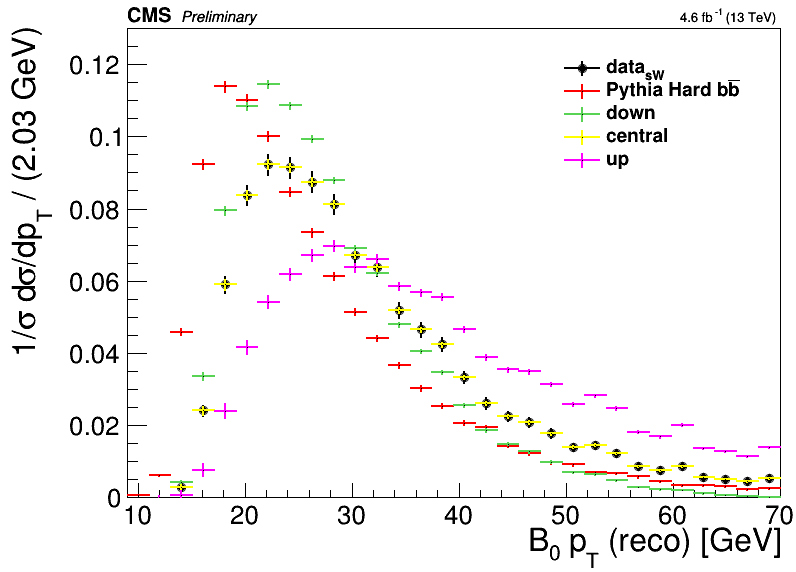

In [61]:
h_var = {}
colors = [5,6,8]
for k in ['central', 'up', 'down']:
    h_var[k] = hMC_hard.Clone('hMC_hard_'+k)
    h_var[k].SetTitle(k)
    h_var[k].SetLineColor(colors[0])
    colors.pop(0)
    
for ib in range(1, hRD.binning[0]+1):
    x = hRD.GetBinCenter(ib)
    y = hMC_hard.GetBinContent(ib)
    h_var['central'].SetBinContent(ib, y*dic['w'][ib-1])
    h_var['up'].SetBinContent(ib, y*dic['wUp'][ib-1])
    h_var['down'].SetBinContent(ib, y*dic['wDown'][ib-1])    

for h in h_var.values():
    h.Scale(1./h.Integral())
    
h_list = [hRD, hMC_hard] + h_var.values()
leg = rt.TLegend(0.7, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
for h in h_list:
    leg.AddEntry(h, h.GetTitle(), 'lep')

h_list[0].GetYaxis().SetRangeUser(0, 0.13)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()

In [ ]:
gr = rt.TGraphErrors()
for ib in range(1, hRD.GetNbinsX()):
    n = max(0, hRD.GetBinContent(ib))
    d = hMC_hard.GetBinContent(ib)
    en = 0.
    ed = 0.
    if n > 0: en = hRD.GetBinError(ib)/n
    if d > 0: ed = hMC_hard.GetBinError(ib)/d
    r = n/d
    if en != 0 and ed != 0:
        dr = r*np.hypot(en, ed)
    elif en == 0:
        dr = 0.5
    gr.SetPoint(ib-1, hRD.GetBinCenter(ib), r)
    gr.SetPointError(ib-1, 0.5*hRD.GetBinWidth(ib), dr)

In [ ]:
# f_fit = rt.TF1('f_fit', '(x>[0]) ? [1]+[2]*x+[3]*x*x : 0', 0, 70)
# # f_fit.FixParameter(0,10)
# f_fit.SetParameters(11, -1, 0.1, 0.001)

f_fit = rt.TF1('f_fit', '[0]+[1]*atan(*x+[2])', 10, 70)


gr.Fit(f_fit, 'MS')

c = rt.TCanvas('c', 'c', 800, 600)
gr.Draw('AP')
c.Draw()